In [1]:
import cv2
import matplotlib.pyplot as plt
from deep_sort_realtime.deepsort_tracker import DeepSort 

import openpifpaf as opp

from PIL import Image
import matplotlib.pyplot as plt

from deep_sort_realtime.deepsort_tracker import DeepSort

import pandas as pd
import numpy as np
from IPython.display import display

/home/alber/anaconda3/envs/masters_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pose_detector = opp.Predictor(checkpoint="shufflenetv2k16")

## OpenPifPaf

In [4]:
pose_detector = opp.Predictor(checkpoint="shufflenetv2k16")
cap = cv2.VideoCapture("../inference/video/panel_dicsussion_1.webm")

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))


# text attributes
font = cv2.FONT_HERSHEY_SIMPLEX
# position = (50, 50)  # (x, y) coordinates
font_scale = 1
font_color = (255, 0, 0)  # BGR color
thickness = 6


rectangle_color = (0, 255, 0)  # BGR color
rectangle_thickness = 4

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('../runs/output_dicsussion_1_video.avi', fourcc, fps, (frame_width, frame_height))



tracker = DeepSort()

frame_id = 0
cat, frame = cap.read()
# 
# 1/0

while cat:

    image = Image.fromarray(frame)

    prediction,_,_ = pose_detector.pil_image(image)

    detections = []

    pose_pred_df = None
        
    ann_painter = opp.show.AnnotationPainter()
    
    with opp.show.image_canvas(image) as ax:

        for pred in prediction:
    
    
            score = pred.score
            cls = str(pred.category_id)
            bbox = [int(cord) for cord in pred.bbox()] # [x,y,w,h]
    
            pose_df = pd.DataFrame()
            pose_df[['bbox_x','bbox_y','bbox_w','bbox_h']] = bbox
    
            detections.append((bbox,score,cls))

            x,y,w,h = bbox

            top_left, bottom_right = (x+w,y+h),(x,y)
            # cv2.rectangle(frame, top_left, bottom_right, (0,0,255), rectangle_thickness)

            if pose_pred_df is None:
    
                pose_pred_df = pose_df.copy()
                continue
    
            pose_pred_df = pd.concat([pose_pred_df,pose_df])
            
        # track
        tracker.update_tracks(detections,frame=frame)
        tracks = tracker.tracker.tracks


        ann_painter.annotations(ax,prediction)
        # opp.show.AnimationFrame(
        # track_pred_df  None

        coords = [det[0] for det in detections]

        for track in tracks:

            x,y,w,h = [int(coord) for coord in track.to_ltwh()]

            # if [x,y,w,h] not in coords:
            #     continue

            
            ID = track.track_id
            top_left, bottom_right = (x+w,y+h),(x,y)
            cv2.putText(frame, "ID: " + ID, (x, y-5), font, font_scale, font_color, thickness)
            cv2.rectangle(frame, top_left, bottom_right, rectangle_color, rectangle_thickness)
            ax.text(x,y,"ID: "+str(ID), color='red')
            rect = plt.Rectangle((x,y),w,h,facecolor='none',edgecolor='green')

            ax.add_patch(rect)
        
        plt.show()

    out.write(frame)


    if frame_id == 10:
        break
    frame_id +=1

    cat,frame = cap.read()
        

    # break

In [6]:
frame

## YOLO 8

### Function data

In [ ]:

import cv2
import numpy as np
import pandas as pd
import os


def get_yolov8_pose_track_coords(pose_result,save_dir,file_name):


    landmarks_list = ["nose", "left_eye", "right_eye", "left_ear", "right_ear", "left_shoulder", 
             "right_shoulder", "left_elbow", "right_elbow", "left_wrist", "right_wrist", 
             "left_hip", "right_hip", "left_knee", "right_knee", "left_ankle", "right_ankle"]

    landmark_body_part = {'nose': "face",
                     'left_eye': "face",
                     'right_eye': "face",
                     'left_ear': "face",
                     'right_ear': "face",
                     'left_shoulder':"upper_limbs",
                     'right_shoulder': "upper_limbs",
                     'left_elbow': "upper_limbs",
                     'right_elbow': "upper_limbs",
                     'left_wrist': "upper_limbs",
                     'right_wrist': "upper_limbs",
                     'left_hip': "lower_limbs",
                     'right_hip': "lower_limbs",
                     'left_knee': "lower_limbs",
                     'right_knee': "lower_limbs",
                     'left_ankle': "lower_limbs",
                     'right_ankle': "lower_limbs"}
    
    key_landmarks = {'nose': "nose",
                     'left_eye': "eye",
                     'right_eye': "eye",
                     'left_ear': "ear",
                     'right_ear': "ear",
                     'left_shoulder':"left_hand",
                     'right_shoulder': "right_hand",
                     'left_elbow': "left_hand",
                     'right_elbow': "right_hand",
                     'left_wrist': "left_hand",
                     'right_wrist': "right_hand",
                     'left_hip': "left_foot",
                     'right_hip': "right_foot",
                     'left_knee': "left_foot",
                     'right_knee': "right_foot",
                     'left_ankle': "left_foot",
                     'right_ankle': "right_foot"}
    
    key_landmarks_as_body_part = {
                                'nose': "nose",
                                'left_eye': "eye",
                                'right_eye': "eye",
                                'left_ear': "ear",
                                'right_ear': "ear",
                                'left_shoulder':"hand",
                                'right_shoulder': "hand",
                                'left_elbow': "hand",
                                'right_elbow': "hand",
                                'left_wrist': "hand",
                                'right_wrist': "hand",
                                'left_hip': "foot",
                                'right_hip': "foot",
                                'left_knee': "foot",
                                'right_knee': "foot",
                                'left_ankle': "foot",
                                'right_ankle': "foot"}

    n_landmarks = len(landmarks_list)
    # cap = cv2.VideoCapture(video_path)

    n_frames = len(pose_result)

    # print(n_frames)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    font_color = (255, 0, 0)  
    thickness = 2
    
    
    full_cord_df = None
    
    
    dict_for_keypoints = {}
    
    for i_frame in range(n_frames):
    
    
        print(f"{'-'*30} FRAME {i_frame+1}/{n_frames} {'-'*30}")
        # plt.figure(figsize=(15,150))
    
    
        # get the frame
        result = pose_result[i_frame]
    
        orig_image = result.orig_img.copy() # get original image
        boxes = result.boxes # get bounding boxes
        keypoints = result.keypoints
    
        n_objects = len(result)
        
        for i_obj in range(n_objects):
    
            box = boxes[i_obj]
            keypoint = keypoints[i_obj]
    
            cls = int(box.cls.item())
            ID = int(box.id.item())
    
            box_x_min,box_y_min,box_x_max,box_y_max = box.xyxy.cpu().numpy()[0].astype(int)
    
            orig_image = cv2.rectangle(orig_image,(box_x_min,box_y_min),(box_x_max,box_y_max),(0,255,0),2)
            orig_image = cv2.putText(orig_image,"ID: "+str(ID),(box_x_min,box_y_min-5),font,font_scale,font_color,thickness)
    
            keypoint_coords = keypoint.xy.cpu().numpy()[0]
    
            # store keypoints in a dictionary to analyse movements
            # if id is not in the dict, add
    
            # id_dict_key = list(dict_for_keypoints.keys())
    
            # if ID not in id_dict_key:
    
                # print("Not")
                # print(landmarks_dict)
                # dict_for_keypoints[ID] = {landmarks_list[i]:[] for i in range(n_landmarks)}.copy()
                # dict_for_keypoints[ID] = copy.deepcopy(landmarks_dict)
            
    
            for pose_i in range(n_landmarks):
    
                pose = keypoint_coords[pose_i]
    
                landmark = landmarks_list[pose_i]
    
                pose_x,pose_y = pose.astype(int)
    
                # if landmarks appears or not
                lanmark_appears = False if  np.all(pose==np.array([0,0])) else True
    
                # dict_for_keypoints[ID][landmark].append([pose_x,pose_y])
    
    
                orig_image = cv2.circle(orig_image,(pose_x,pose_y),5,(0,0,255),-1)
    
                body_part = landmark_body_part[landmark]
                
                
                key_landmark = key_landmarks[landmark]
                key_landmark_as_body_part = key_landmarks_as_body_part[landmark]
    
                inner_df = pd.DataFrame({"Frame":[i_frame],
                                         "ID":[ID],
                                         "Landmark":[landmark],
                                         "LandmarkApears": [lanmark_appears],
                                         "BodyPart":[body_part],
                                         "RightLeftKeyLandmark":[key_landmark],
                                         "KeyLandmark" : [key_landmark_as_body_part],
                                         "Pose_X":[pose_x],
                                         "Pose_Y":[pose_y],
                                         "bbox_x_min":[box_x_min],
                                         "bbox_y_min":[box_y_min],
                                         "bbox_x_max":[box_x_max],
                                         "bbox_y_max":[box_y_max]
                                        })
    
                if full_cord_df is None:
                    full_cord_df = inner_df.copy()
    
                    continue
    
                full_cord_df = pd.concat([full_cord_df,inner_df])


    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        # full_cord_df.to_csv(os.path.join(save_dir,file_name),index=False)
        
    full_cord_df.to_csv(os.path.join(save_dir,file_name),index=False)
    
    return full_cord_df
        

### Functions vis


In [132]:



def plot_individual_results(df,suptitle=None):

    df.sort_values(['Frame','ID'],inplace=True)


    # unique ids
    unique_ids = df.ID.unique()
    n_unique = len(unique_ids)
    # n_frames = df['n_frames'].values[0]
    # x_axis = np.arange(1,n_frames+1)

    fig,ax = plt.subplots(n_unique,3)

    # title
    suptitle = "Visualization of metrics for behavior for each ID in each frame" if suptitle is None else suptitle
    fig.suptitle(suptitle,fontsize=20)
    
    
    fig.set_figwidth(15)
    fig.set_figheight(15)
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.5)
    
    for i in range(n_unique):

        ID = unique_ids[i]
        
        id_df = df[df['ID'] == ID].copy()

        # mean coordinates

        mean_pose_x = id_df['Mean_Pose_X_PerID_EachFrame'].values
        mean_pose_y = id_df['Mean_Pose_Y_PerID_EachFrame'].values
        face_feet_distance_ec = id_df['FaceToLoerLimbs_Euclidean'].values
        face_feet_distance_mn = id_df['FaceToLoerLimbs_Manhattan'].values
        face_to_front = id_df['FaceToFrontEachFrame'].values
        
        x_axis = id_df['Frame'].values

        # mean points
        ax[i][0].plot(x_axis,mean_pose_x,label='Mean keypoints X')
        ax[i][0].plot(x_axis,mean_pose_y,label='Mean keypoints Y')
        ax[i][0].set_xlabel("Frame")
        ax[i][0].set_ylabel("Coordinate value")
        ax[i][0].legend()
        ax[i][0].set_title("ID: "+str(ID)+"\nMean of keypoints for each frame")

        # distances
        ax[i][1].plot(x_axis,face_feet_distance_ec,label='Euclidean')
        ax[i][1].plot(x_axis,face_feet_distance_mn,label='Manhattan')
        ax[i][1].set_xlabel("Frame")
        ax[i][1].set_ylabel("Distance")
        ax[i][1].legend()
        ax[i][1].set_title("ID: "+str(ID)+"\nDistance between face to lower limbs")


        # face to front
        ax[i][2].plot(x_axis,face_to_front)
        ax[i][2].set_ylabel("Precent")
        # ax[i][2].legend()
        ax[i][2].set_xlabel("Frame")

        ax[i][2].set_title("ID: "+str(ID)+"\nFace to front ratio")
        
    plt.show()
        # break

        





def plot_total_metrics_each_frame(df,suptitle=None):


    fig,ax = plt.subplots(3,1)

    # title
    suptitle = "Visualization of metrics for behavior in each frame" if suptitle is None else suptitle
    fig.suptitle(suptitle,fontsize=20)
    
    
    fig.set_figwidth(15)
    fig.set_figheight(10)
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.5)

    x_axis = df['Frame'].values
    pose_x = df['Mean_Pose_X_EachFrame'].values
    pose_y = df['Mean_Pose_Y_EachFrame'].values
    ec = df['FaceToLoerLimbs_Euclidean'].values
    mn = df['FaceToLoerLimbs_Manhattan'].values
    ftf = df['FaceToFrontEachFrame'].values

    ax[0].plot(x_axis,pose_x,label='Keypoints X')
    ax[0].plot(x_axis,pose_y,label='Keyponts Y')
    ax[0].set_xlabel("Frame")
    ax[0].set_ylabel("Coordinate value")
    ax[0].set_title("Mean coordinates of keypoints for each frame")
    ax[0].legend()

    ax[1].plot(x_axis,ec,label='Euclidean')
    ax[1].plot(x_axis,mn,label='Manhattan')
    ax[1].set_xlabel("Frame")
    ax[1].set_ylabel("Distance")
    ax[1].set_title("Mean face to lower limbs distance for each frame") 
    ax[1].legend()

    ax[2].plot(x_axis,ftf)
    ax[2].set_xlabel("Frame")
    ax[2].set_ylabel("Percent")
    ax[2].set_title("Face to front ratio") 
    plt.show()
    
def plot_total_metrics_each_id(data,suptitle=None):

    df = data[data['LandmarkApears']].copy()

    unique_ids = df.ID.unique()
    n_unique_ids = len(unique_ids)

    key_points = full_cord_df_yolov8.BodyPart.unique()
    n_keypoints = len(key_points)

    for i in range(n_unique_ids):

        ID = unique_ids[i]

        id_df = df[df['ID'] == ID]

        fig,ax = plt.subplots(n_keypoints,2)

        fig.suptitle("Distribution of body parts coordinate movements for ID: " + str(ID),fontsize=20)

        fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.5)
        fig.set_figheight(15)
        fig.set_figwidth(15)

        for i_key in range(n_keypoints):

            keypoint = key_points[i_key]

            id_df_key = id_df[id_df['BodyPart'] == keypoint]

            pose_x,pose_y = id_df_key['Pose_X'],id_df_key['Pose_Y']
            x_axis = id_df_key['Frame'].values

            if keypoint == "lower_limbs":
                title = "Feet"
            elif keypoint == "upper_limbs":
                title = "Hand"
            else:
                title = keypoint
                
            ax[i_key][0].hist(pose_x)
            ax[i_key][0].set_xlabel("X coordinates")
            ax[i_key][0].set_title(title.capitalize())
            
            ax[i_key][1].hist(pose_y)
            ax[i_key][1].set_xlabel("Y coordinates")
            ax[i_key][1].set_title(title.capitalize())
        plt.show()
        break
        
    pass
    


        
        # pass

    # return unique_ids

### Code

In [17]:
from ultralytics import YOLO
# from utils.get_coordinates import get_yolov8_pose_track_coords

In [3]:
model = YOLO("yolov8n.pt")
pose_model = YOLO("yolov8m-pose.pt")

In [4]:
pose_results = pose_model.track("../inference/video/panel_dicsussion_1.webm",show=True,save=True,save_dir='../runs/')



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/744) /home/alber/Desktop/DSB3/MastersThesis/HumanPoseDetection/src/../inference/video/panel_dicsussion_1.webm: 384x640 4 persons, 38.7ms
video 1/1 (frame 2/744) /home/alber/Desktop/DSB3/MastersThesis/HumanPoseDetection/src/../inference/video/panel_dicsussion_1.webm: 384x640 4 persons, 36.5ms
video 1/1 (frame 3/744) /home/alber/Desktop/DSB3/MastersThesis/HumanPoseDetection/src/../inference/video/panel_dicsussion_1.webm: 384x640 4 pers

In [5]:
len(pose_results)

744

In [8]:
# full_cord_df_yolov8 = get_yolov8_pose_track_coords(pose_results,"coord_data/","panel_discussion_yolov8_pose_track_updated.csv")
full_cord_df_yolov8 = pd.read_csv("coord_data/panel_discussion_yolov8_pose_track_updated.csv")

In [9]:
full_cord_df_yolov8.head()

,Frame,ID,Landmark,LandmarkApears,BodyPart,RightLeftKeyLandmark,KeyLandmark,Pose_X,Pose_Y,bbox_x_min,bbox_y_min,bbox_x_max,bbox_y_max
0,0,1,nose,True,face,nose,nose,896,198,804,139,1035,628
1,0,1,left_eye,True,face,eye,eye,911,189,804,139,1035,628
2,0,1,right_eye,True,face,eye,eye,890,185,804,139,1035,628
3,0,1,left_ear,True,face,ear,ear,945,195,804,139,1035,628
4,0,1,right_ear,True,face,ear,ear,885,186,804,139,1035,628


### Get patterns

In [21]:
# mean coords for id in each frame
# mean coords for each 

def get_patterns(df):

    
    n_frames = df['Frame'].values[-1]+1
    unique_ids = df.ID.unique()
    n_unique_ids = len(unique_ids)
    # only rows that where any keypoint appears
    df_not_zero = df[df['LandmarkApears']].copy()


    # inidivual scores
    # ------------------------------------------------------------------------------------------------------------------------------#


    # mean for each id in each frame
    df_mean_1 = df_not_zero[['Frame','ID','Pose_X','Pose_Y']].copy()
    df_mean_1 = df_mean_1.groupby(['Frame','ID'])[['Pose_X','Pose_Y']]\
                            .mean().round(decimals=2).add_prefix("Mean_").add_suffix("_PerID_EachFrame")\
                            .reset_index()


    # distance between face to lower limb
    df_face = df_not_zero[df_not_zero['BodyPart']=='face'].copy()
    df_lower_limbs = df_not_zero[df_not_zero['BodyPart']=='lower_limbs'].copy()
    
    df_face = df_face.groupby(['Frame','ID'])[['Pose_X','Pose_Y']]\
                            .mean().round(decimals=2).add_prefix("Face_")\
                            .reset_index()
    df_lower_limbs = df_lower_limbs.groupby(['Frame','ID'])[['Pose_X','Pose_Y']]\
                            .mean().round(decimals=2).add_prefix("LowerLimbs_")\
                            .reset_index()
    
    df_face_lower_limbd_distance = df_face.merge(df_lower_limbs,on=['Frame','ID'])

    # Euclidean Distance 
    df_face_lower_limbd_distance['FaceToLoerLimbs_Euclidean'] = \
                    np.sqrt((df_face_lower_limbd_distance['Face_Pose_X']-df_face_lower_limbd_distance['LowerLimbs_Pose_X'])**2 + 
                            (df_face_lower_limbd_distance['Face_Pose_Y']-df_face_lower_limbd_distance['LowerLimbs_Pose_Y'])**2).round(2)
    
    # Manhattan Distance 
    df_face_lower_limbd_distance['FaceToLoerLimbs_Manhattan'] = \
                    abs(df_face_lower_limbd_distance['Face_Pose_X']-df_face_lower_limbd_distance['LowerLimbs_Pose_X']) +\
                    abs(df_face_lower_limbd_distance['Face_Pose_Y']-df_face_lower_limbd_distance['LowerLimbs_Pose_Y'])

    
    df_face_lower_limbd_distance = df_face_lower_limbd_distance[['Frame','ID','FaceToLoerLimbs_Euclidean','FaceToLoerLimbs_Manhattan']]

    # number of face for each ID in each frame
    df_face = df_not_zero[df_not_zero['BodyPart']=='face'][['Frame','ID','BodyPart']].copy()
    df_face = df_face.groupby(['Frame','ID'],as_index=False)['BodyPart'].count().rename(columns={"BodyPart":"ActualFaceCount"})
    df_face['RealFaceCount'] = 5
    df_face['FaceToFrontEachFrame'] = df_face['ActualFaceCount']/df_face['RealFaceCount'].round(2) * 100
    
    # return df_face
    # df_face_ = df_face.groupby("ID")[['RealFaceCount','ActualFaceCount']].sum().reset_index()
    # df_face_['TotalFaceToFront'] = df_face_['ActualFaceCount']/df_face_['RealFaceCount'].round(2) * 100
    # df_face_ = df_face_[['ID','TotalFaceToFront']]

    # df_face = df_face[['Frame','ID','FaceToFrontEachFrame']].merge(df_face_,on='ID')


    
    # scores
    individual_scores_df = df_mean_1.merge(df_face_lower_limbd_distance,on=['Frame','ID'])
    individual_scores_df = individual_scores_df.merge(df_face,on=['Frame','ID'])
    individual_scores_df['n_frames'] = n_frames

    individual_scores_df.drop_duplicates(inplace=True)


    # total scores each frame
    # ------------------------------------------------------------------------------------------------------------------------------#


    df_mean_1 = df_not_zero.copy()
    df_mean_1 = df_mean_1.groupby('Frame')[['Pose_X','Pose_Y']]\
                            .mean().round(decimals=2).add_prefix("Mean_").add_suffix("_EachFrame")\
                            .reset_index()
    
    # distance between face to lower limb
    df_face = df_not_zero[df_not_zero['BodyPart']=='face'].copy()
    df_lower_limbs = df_not_zero[df_not_zero['BodyPart']=='lower_limbs'].copy()
    
    df_face = df_face.groupby('Frame')[['Pose_X','Pose_Y']]\
                            .mean().round(decimals=2).add_prefix("Face_")\
                            .reset_index()
    df_lower_limbs = df_lower_limbs.groupby('Frame')[['Pose_X','Pose_Y']]\
                            .mean().round(decimals=2).add_prefix("LowerLimbs_")\
                            .reset_index()
    
    df_face_lower_limbd_distance = df_face.merge(df_lower_limbs,on='Frame')

    # Euclidean Distance 
    df_face_lower_limbd_distance['FaceToLoerLimbs_Euclidean'] = \
                    np.sqrt((df_face_lower_limbd_distance['Face_Pose_X']-df_face_lower_limbd_distance['LowerLimbs_Pose_X'])**2 + 
                            (df_face_lower_limbd_distance['Face_Pose_Y']-df_face_lower_limbd_distance['LowerLimbs_Pose_Y'])**2).round(2)
    
    # Manhattan Distance 
    df_face_lower_limbd_distance['FaceToLoerLimbs_Manhattan'] = \
                    abs(df_face_lower_limbd_distance['Face_Pose_X']-df_face_lower_limbd_distance['LowerLimbs_Pose_X']) +\
                    abs(df_face_lower_limbd_distance['Face_Pose_Y']-df_face_lower_limbd_distance['LowerLimbs_Pose_Y'])

    
    df_face_lower_limbd_distance = df_face_lower_limbd_distance[['Frame','FaceToLoerLimbs_Euclidean','FaceToLoerLimbs_Manhattan']]

    # faces
    df_face = df_not_zero[df_not_zero['BodyPart']=='face'][['Frame','BodyPart']].copy()
    df_face = df_face.groupby('Frame',as_index=False)['BodyPart'].count().rename(columns={"BodyPart":"ActualFaceCount"})
    df_face['RealFaceCount'] = 5 * n_unique_ids
    df_face['FaceToFrontEachFrame'] = df_face['ActualFaceCount']/df_face['RealFaceCount'].round(2) * 100
    
    # return df_face
    # df_face_ = df_face.groupby("Frame")[['RealFaceCount','ActualFaceCount']].sum().reset_index()
    # df_face_['TotalFaceToFront'] = df_face_['ActualFaceCount']/df_face_['RealFaceCount'].round(2) * 100
    # df_face_ = df_face_[['Frame','TotalFaceToFront']]

    df_face = df_face[['Frame','FaceToFrontEachFrame']]

    # return df_face_lower_limbd_distance
    each_frame_scores = df_mean_1.merge(df_face_lower_limbd_distance,on='Frame')
    each_frame_scores = each_frame_scores.merge(df_face,on='Frame')



    # total scores each ID
    # ------------------------------------------------------------------------------------------------------------------------------#

    df_mean_1 = df_not_zero.copy()
    df_mean_1 = df_mean_1.groupby('ID')[['Pose_X','Pose_Y']]\
                            .mean().round(decimals=2).add_prefix("Mean_").add_suffix("_EachID")\
                            .reset_index()
    df_std_1 = df_not_zero.copy()
    df_std_1 = df_std_1.groupby('ID')[['Pose_X','Pose_Y']]\
                            .std().round(decimals=4).add_prefix("STD_").add_suffix("_EachID")\
                            .reset_index()
    df_mean_1 = df_mean_1.merge(df_std_1,on='ID')
    # distance between face to lower limb
    df_face = df_not_zero[df_not_zero['BodyPart']=='face'].copy()
    df_lower_limbs = df_not_zero[df_not_zero['BodyPart']=='lower_limbs'].copy()
    
    df_face = df_face.groupby('ID')[['Pose_X','Pose_Y']]\
                            .mean().round(decimals=2).add_prefix("Face_")\
                            .reset_index()
    df_lower_limbs = df_lower_limbs.groupby('ID')[['Pose_X','Pose_Y']]\
                            .mean().round(decimals=2).add_prefix("LowerLimbs_")\
                            .reset_index()
    
    df_face_lower_limbd_distance = df_face.merge(df_lower_limbs,on='ID')

    # Euclidean Distance 
    df_face_lower_limbd_distance['FaceToLoerLimbs_Euclidean'] = \
                    np.sqrt((df_face_lower_limbd_distance['Face_Pose_X']-df_face_lower_limbd_distance['LowerLimbs_Pose_X'])**2 + 
                            (df_face_lower_limbd_distance['Face_Pose_Y']-df_face_lower_limbd_distance['LowerLimbs_Pose_Y'])**2).round(2)
    
    # Manhattan Distance 
    df_face_lower_limbd_distance['FaceToLoerLimbs_Manhattan'] = \
                    abs(df_face_lower_limbd_distance['Face_Pose_X']-df_face_lower_limbd_distance['LowerLimbs_Pose_X']) +\
                    abs(df_face_lower_limbd_distance['Face_Pose_Y']-df_face_lower_limbd_distance['LowerLimbs_Pose_Y'])

    
    df_face_lower_limbd_distance = df_face_lower_limbd_distance[['ID','FaceToLoerLimbs_Euclidean','FaceToLoerLimbs_Manhattan']]

    # faces
    df_face = df_not_zero[df_not_zero['BodyPart']=='face'][['ID','BodyPart']].copy()
    df_face = df_face.groupby('ID',as_index=False)['BodyPart'].count().rename(columns={"BodyPart":"ActualFaceCount"})
    # return df_face
    df_face['RealFaceCount'] = 5 * n_frames
    df_face['FaceToFrontEachID'] = df_face['ActualFaceCount']/df_face['RealFaceCount'].round(2) * 100


    df_face = df_face[['ID','FaceToFrontEachID']]

    # return df_face_lower_limbd_distance
    each_id_scores = df_mean_1.merge(df_face_lower_limbd_distance,on='ID')
    each_id_scores = each_id_scores.merge(df_face,on='ID')

    return individual_scores_df,each_frame_scores,each_id_scores

    # return df_not_zero.shape,df.shape

### Visual

In [30]:
output_frame_id,output_frame,output_id = get_patterns(full_cord_df_yolov8)
output_frame_id.head()

,Frame,ID,Mean_Pose_X_PerID_EachFrame,Mean_Pose_Y_PerID_EachFrame,FaceToLoerLimbs_Euclidean,FaceToLoerLimbs_Manhattan,ActualFaceCount,RealFaceCount,FaceToFrontEachFrame,n_frames
0,0,1,920.94,342.88,285.58,312.00,5,5,100.0,744
1,0,2,490.41,348.65,290.76,319.00,5,5,100.0,744
2,0,3,704.59,344.76,282.30,292.70,5,5,100.0,744
3,1,1,921.06,342.65,285.09,311.50,5,5,100.0,744
4,1,2,490.41,348.41,291.68,319.57,5,5,100.0,744


In [25]:
full_cord_df_yolov8.head()

,Frame,ID,Landmark,LandmarkApears,BodyPart,RightLeftKeyLandmark,KeyLandmark,Pose_X,Pose_Y,bbox_x_min,bbox_y_min,bbox_x_max,bbox_y_max
0,0,1,nose,True,face,nose,nose,896,198,804,139,1035,628
0,0,1,left_eye,True,face,eye,eye,911,189,804,139,1035,628
0,0,1,right_eye,True,face,eye,eye,890,185,804,139,1035,628
0,0,1,left_ear,True,face,ear,ear,945,195,804,139,1035,628
0,0,1,right_ear,True,face,ear,ear,885,186,804,139,1035,628


In [31]:
full_cord_df_yolov8.KeyLandmark.unique()

array(['nose', 'eye', 'ear', 'hand', 'foot'], dtype=object)

In [136]:
# full_cord_df_yolov8.head()

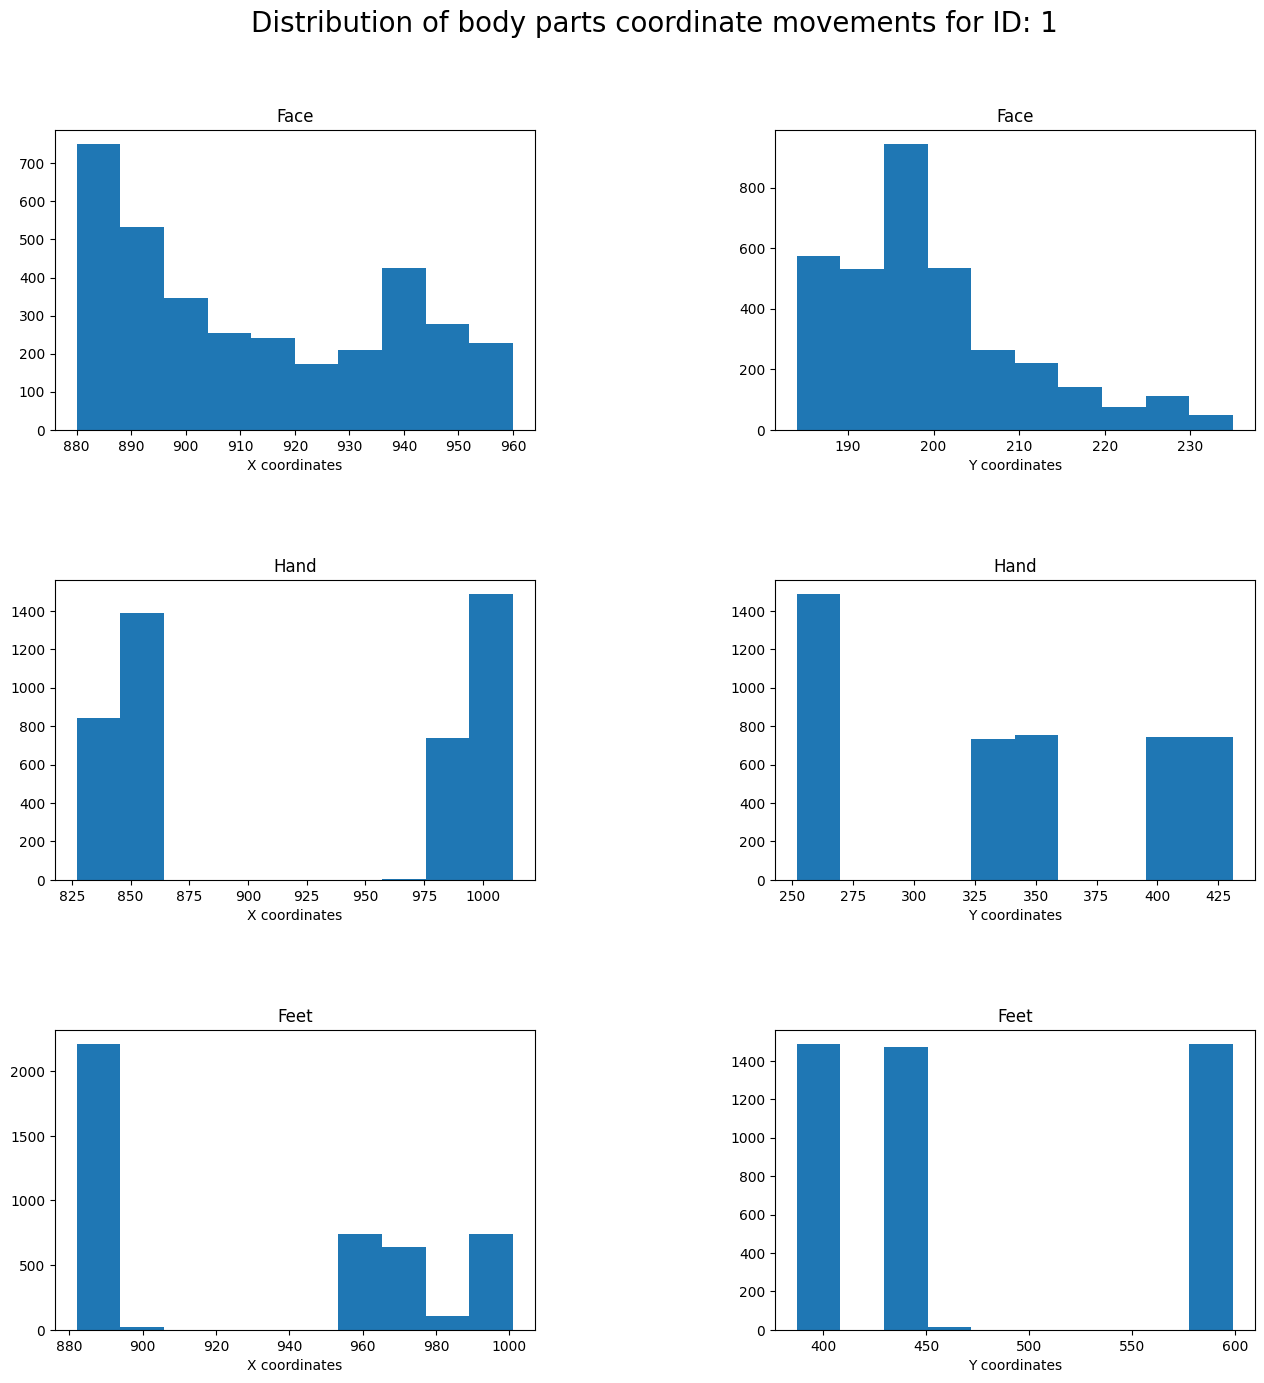

In [137]:
plot_total_metrics_each_id(full_cord_df_yolov8)

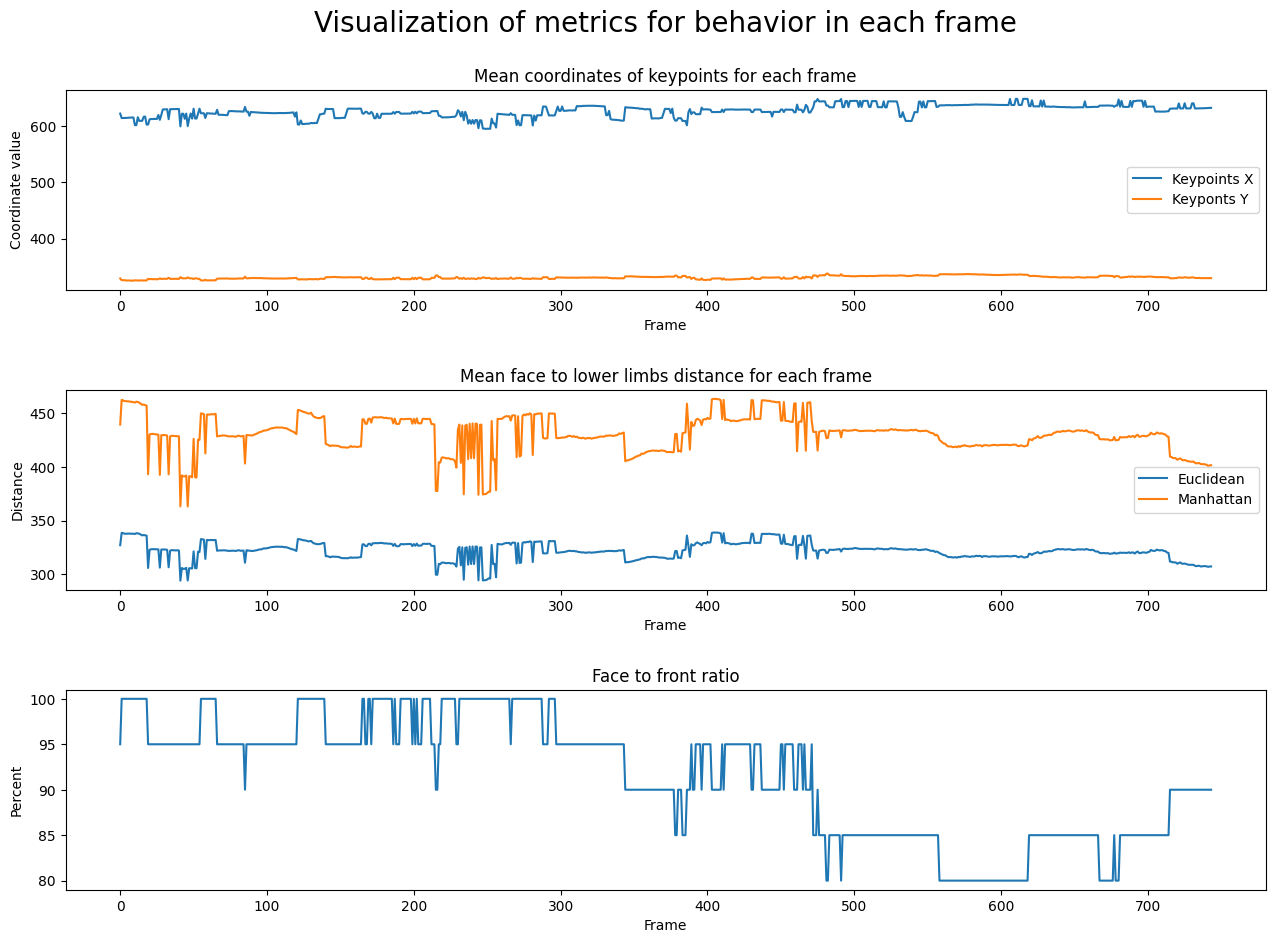

In [138]:
plot_total_metrics_each_frame(output_frame)

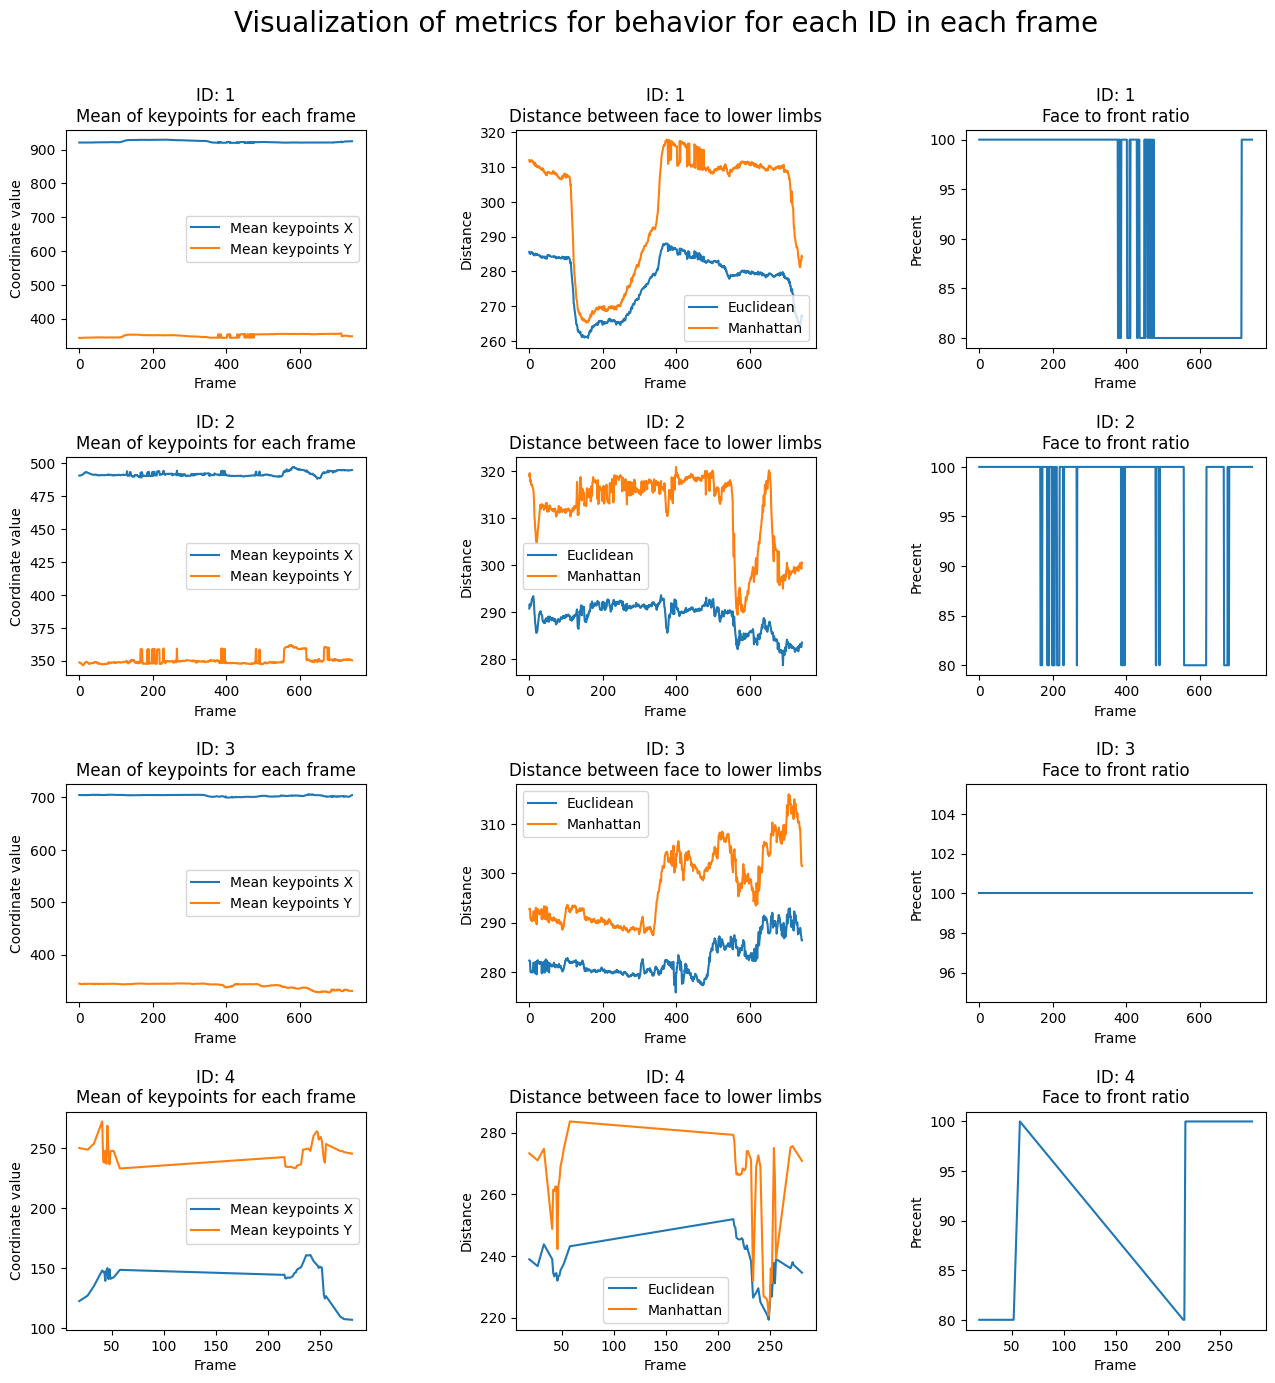

In [139]:
plt_output = plot_individual_results(output_frame_id)
plt_output